In [15]:
import torch
import os
import matplotlib.pyplot as plt
from torchvision import transforms
script_dir = os.path.abspath(".")
data_dir = os.path.join(script_dir, 'data')
model_path = os.path.join(script_dir, 'playground', 'unet_model_reduced_classes.pth')

from models.UNetKernelSize import UNetKernelSize
from scripts.dataloader import get_dataloaders
from playground.testimports import CustomImageDataset
from scripts.inferencetimer import experiment
import pickle as pkl
from scripts.inferencetimer import t_test

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


Custom data loader for reduced classes:

In [3]:
transform = transforms.Compose([
    transforms.Resize((572, 572)),
    transforms.ToTensor()
])

dummy_dataset = CustomImageDataset(
    images_dir=os.path.join(data_dir, 'train'),
    labels_dir=os.path.join(data_dir, 'train_labels'),
    class_dict_csv=os.path.join(data_dir, 'class_dict.csv'),
    transform=transform
)

num_classes = len(dummy_dataset.class_dict)
model = UNetKernelSize(in_channels=3, num_classes=num_classes, kernel_size=3).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))


<All keys matched successfully>

In [4]:
_, _, test_loader, _ = get_dataloaders(batch_size=1, pin_memory=True)

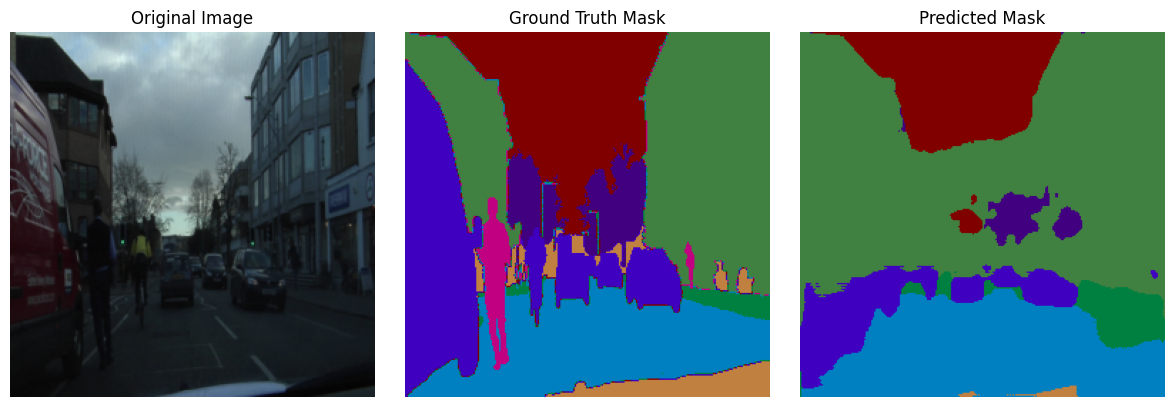

In [5]:
for i in range(1): 
    image_tensor, label_tensor = test_loader.dataset[i]

    input_tensor = image_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        predicted_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    ground_truth_mask = label_tensor.cpu().numpy()
    rgb_pred = dummy_dataset.class_id_to_rgb(predicted_mask)
    rgb_gt = dummy_dataset.class_id_to_rgb(ground_truth_mask)

    # Plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image_tensor.permute(1, 2, 0).cpu().numpy())
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(rgb_gt)
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(rgb_pred)
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

We used alot of time making a model that would segment the images better, and since we wanted access to the structure of the model, we decided to base our model on the UNet architecture. Our first attempts was using a kernel size 2x2 and had the original lables, but we quickly realized that the model was not able to learn anything. We then changed the kernel size to 3x3 and changed the labels to a reduced set of classes (8 classes) that was more general. EG: instead of car and truck, we only had vehicle. Increasing the kernel size added to training time and inference increased (We dont have exact numbers here due to having split up work over different computers). With this in mind we decided that the 3x3 kernel size was going to be used as the baseline for the future experiments.

In [6]:
# Wrap your test sample into a list for the experiment function
test_samples = [(input_tensor.cpu(), label_tensor.unsqueeze(0)) for _ in range(100)]  # Ensure shape matches what experiment expects
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [7]:
# The pickle is a list of all the pruned models and their results (this is to large to push on github but this can be skipped)
try:
    with open(os.path.join(script_dir, 'scripts', 'pruning_results.pkl'), 'rb') as f:
        results = pkl.load(f)
    skip = False
    all_models, all_amounts, all_losses = results
    pruning_amounts = [0.01,0.025,0.05,0.07,0.1,0.125,0.15,0.175,0.2,0.225,0.25,0.275,0.3,0.325,0.35,0.375,0.4,0.425,0.45,0.475,0.5]
except FileNotFoundError:
    skip = True

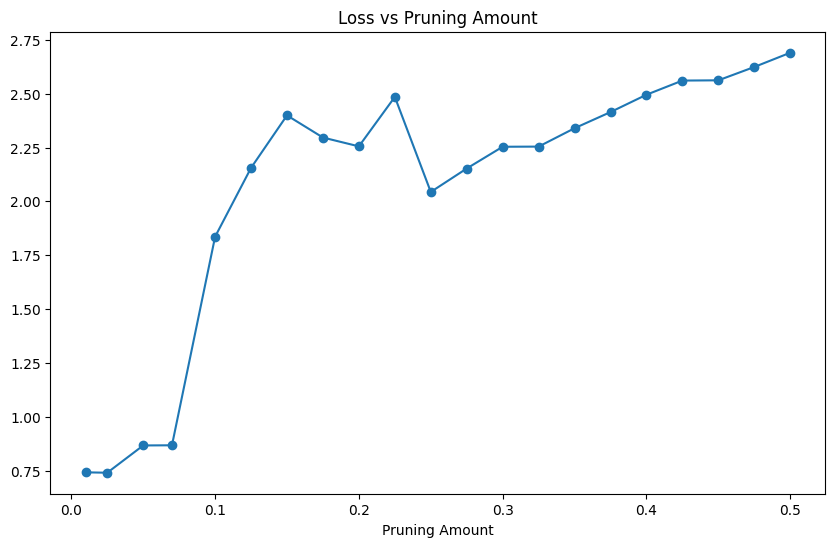

In [8]:
if skip == False:
    # plot the losses against the pruning amounts
    plt.figure(figsize=(10, 6))
    plt.plot(pruning_amounts, all_losses, marker='o')
    plt.title("Loss vs Pruning Amount")
    plt.xlabel("Pruning Amount")


From this image we see that the model is degrading rather fast with pruning, perhaps indicating that the model is already of correct size, with this in mind we should not prune beyond 0.07

# Experiments

In [9]:
# non prunded model
model = UNetKernelSize(in_channels=3, num_classes=num_classes, kernel_size=3).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
avg_time_per_sample, avg_loss, timers = experiment(model, test_samples)
print(f"Average time per sample: {avg_time_per_sample:.4f} seconds")
print(f"Average loss: {avg_loss:.4f}")

100%|██████████| 100/100 [01:49<00:00,  1.09s/it]

Average time per sample: 1.0904 seconds
Average loss: 1.1706


In [10]:
if skip == False:
    # do the experiement on the 0.07 pruned model
    model = all_models[3]
    avg_time_per_sample1, avg_loss1, timers1 = experiment(model, test_samples)
    print(f"Average time per sample: {avg_time_per_sample1:.4f} seconds")
    print(f"Average loss: {avg_loss1:.4f}")
    


100%|██████████| 100/100 [01:54<00:00,  1.14s/it]


Average time per sample: 1.1412 seconds
Average loss: 1.1692


In [11]:
if skip == False:
    model = all_models[8]
    avg_time_per_sample2, avg_loss2, timers2 = experiment(model, test_samples)
    print(f"pruning amount: {pruning_amounts[8]}")
    print(f"Average time per sample: {avg_time_per_sample2:.4f} seconds")
    print(f"Average loss: {avg_loss2:.4f}")
    

if skip == False:
        
    model = all_models[16]
    avg_time_per_sample3, avg_loss3, timers3 = experiment(model, test_samples)
    print(f"pruning amount: {pruning_amounts[16]}")
    print(f"Average time per sample: {avg_time_per_sample3:.4f} seconds")
    print(f"Average loss: {avg_loss3:.4f}")
    

100%|██████████| 100/100 [01:52<00:00,  1.13s/it]


pruning amount: 0.2
Average time per sample: 1.1229 seconds
Average loss: 2.1147


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


pruning amount: 0.4
Average time per sample: 1.1357 seconds
Average loss: 2.5144


In [ ]:
t_test1 = t_test(timers, timers1)
t_test2 = t_test(timers, timers2)
t_test3 = t_test(timers, timers3)



T-statistic: -5.4069825102284845, P-value: 1.834092008494019e-07
The difference is statistically significant.
T-statistic: -3.499280812810885, P-value: 0.0005761685633838813
The difference is statistically significant.
T-statistic: -5.384156168211119, P-value: 2.0490228988602707e-07
The difference is statistically significant.


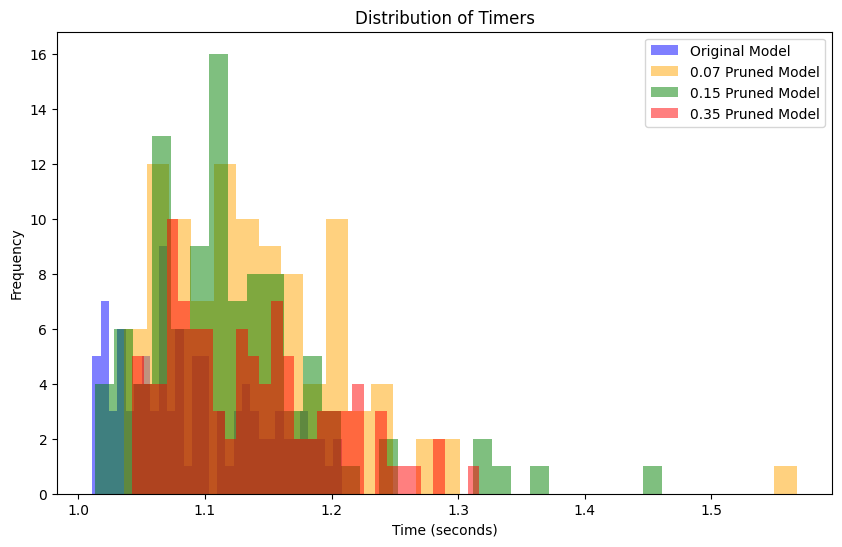

In [17]:
# plot the distriubution of the timers
plt.figure(figsize=(10, 6))
plt.hist(timers, bins=30, alpha=0.5, label='Original Model', color='blue')
plt.hist(timers1, bins=30, alpha=0.5, label='0.07 Pruned Model', color='orange')
plt.hist(timers2, bins=30, alpha=0.5, label='0.15 Pruned Model', color='green')
plt.hist(timers3, bins=30, alpha=0.5, label='0.35 Pruned Model', color='red')
plt.title("Distribution of Timers")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


Since we see no meaningfull changes in the results when using harser pruning we found out that the pytorch model does not actually remove the weights, but rather just sets them to zero. This means that the model is still the same size, despite not using "all" the weights. As such the model is still the same size, and does not improve on inference. To achieve improved inference we would have to retrain, most likely with a smaller model, which we from the model performance image can see is at about a 0.07 pruning rate. meaning each layer could have about 7% of the weights removed. 

We do get that the distribution of the timers are significantly different (using a t-test on 0.05) however from what we can see the model is not actually smaller, and as such we do not get any performance increase, and we believe other factors from the hardware is the reason for the difference in inference time.